In [1]:
#note: need pytorch for this
import json
import numpy as np
import torch
import math
from torch import nn
from torch import cuda
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from statistics import mean, stdev


In [17]:
#open data
#open up the stock json file
with open(r"C:\Users\Brian\Desktop\ML\project\data\all_data_dvsize20.json", "r") as f:
    data = json.loads(f.read())
#prepare data for usage with pytorch
#needs to be tensor of shape (batch_size, sequence_lenght, num_features)
#batch size could just be all of the samples 
#so X[0] = sample 0, X[0][0] = the features for sample 0 at time step 0
num_samples = len(data)

seq_length = len(data[0].get('stock_data')) #all the time steps, probably dont want this many
#Modify this and see how loss responds 
seq_length = 10

num_features = 4      #use open, high, low, close
num_news_features = 20  #may change

X = np.zeros((num_samples,seq_length,num_features))
X_news = np.zeros((num_samples, num_news_features))
y = np.zeros((num_samples,num_features)) #next day features, what we want to predict. [open high low close]
for i,d in enumerate(data):
    doc_feat = d.get("docvec")
    X_news[i] = doc_feat
    sd = d.get("stock_data")
    rec_feat = []
    k=0
    for j,day in enumerate(sd):
        #only grab the seq_length most recent days
        if j < (len(sd)-seq_length-1):
            continue
        #if its the last day, use as prediction
        if j == len(sd)-1:
            y[i] = [sd.get(day).get("open"), sd.get(day).get("high"), sd.get(day).get("low"), sd.get(day).get("close")]
            break
        
        #feature for 1 time stamp
        x = [sd.get(day).get("open"), sd.get(day).get("high"), sd.get(day).get("low"), sd.get(day).get("close")] 
            #sd.get(day).get("volume")]    
        X[i,k]=x
        k+=1

#do the train test split manually, so we can get the indices too
train_inds = [random.randint(0, len(X)-1) for iter in range(math.floor((len(X)-1) * 0.8))]
test_inds = np.setdiff1d(np.arange(0, len(X)-1), train_inds)

X_train = torch.from_numpy(X[train_inds]).type(torch.DoubleTensor)
X_news_train = torch.from_numpy(X_news[train_inds]).type(torch.DoubleTensor)
y_train = torch.from_numpy(y[train_inds]).type(torch.DoubleTensor)
X_test = torch.from_numpy(X[test_inds]).type(torch.DoubleTensor)
X_news_test = torch.from_numpy(X_news[test_inds]).type(torch.DoubleTensor)
y_test = torch.from_numpy(y[test_inds]).type(torch.DoubleTensor)        

X_news = torch.from_numpy(X_news).type(torch.DoubleTensor)
X = torch.from_numpy(X).type(torch.DoubleTensor)
y = torch.from_numpy(y).type(torch.DoubleTensor)

In [18]:
is_cuda = torch.cuda.is_available()
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [19]:
class news_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, doc_feat_size):
        super(news_LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        hh = math.floor((hidden_size + doc_feat_size) / 2)
        
        self.fc1 = nn.Linear(hidden_size + doc_feat_size, hh)
        self.fc2 = nn.Linear(hh, 1)
        
    def forward(self, input, news_feat):
        out = self.lstm(input)
        out = out[0][-1]     #get the output from the last time step
        news_feat = news_feat.float()
        
        concat = torch.cat((out[0], news_feat),0).float()
        fc_out = self.fc1(concat)
        fc_out = self.relu(fc_out)
        fc_out = self.fc2(fc_out)
        out = fc_out     
        
        return out

#Modify this and see how loss responds 
n_hidden = 100

model = news_LSTM(num_features, n_hidden, 1, num_news_features).float()

# Define hyperparameters
n_epochs = 100
lr=0.01

# Define Loss, Optimizer
criterion = nn.L1Loss()
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9) #best performance so far
#try different optimizers! : https://pytorch.org/docs/stable/optim.html

In [20]:
#training function
def train(x, y, news_feat):  #x would be a whole training sample, so all time steps:
    model.train()
    optimizer.zero_grad()
    #need to reshape x from [seq_len feats] to [seq_len 0 feats]
    x = x.view(seq_length,1,num_features).float()
    
    #for ts in x:
    #    ts = torch.tensor(np.reshape(ts,(1,ts.shape[0]))).float()
    output = model(x, news_feat)
        
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
     # Add parameters' gradients to their values, multiplied by learning rate
    #for p in model.parameters():
    #    p.data.add_(-lr, p.grad.data)
    return output, loss.item()

#testing function
def test(x, news_feat):
    model.eval()
    x = x.view(seq_length,1,num_features).float()
    output = model(x, news_feat)
    y_pred = output
    return y_pred

#helper function for modifying the learning rate
def adjust_learning_rate(optimizer, epoch):
    if epoch % 10 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.5


0.01
0.005
0.0025
0.00125
0.000625
0.0003125
0.00015625
7.8125e-05
3.90625e-05
1.953125e-05


<IPython.core.display.Javascript object>


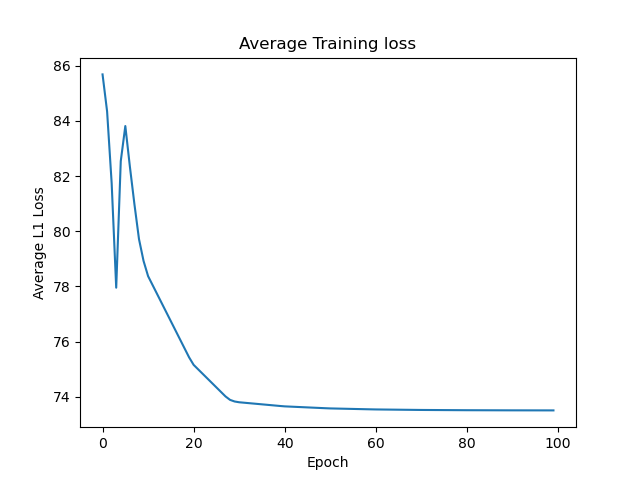

Text(0, 0.5, 'Average L1 Loss')

In [34]:
# Run the training procedure
#device = torch.device("cpu")
#model.to(device)
#X.to(device)
#y.to(device)
losses=[]
for epoch in range(1, n_epochs + 1):
    #optimizer.zero_grad() # Clears existing gradients from previous epoch
    l=0
    for i,x in enumerate(X_train):
        target = torch.tensor([y_train[i,0]])
        output, loss = train(x, target, X_news_train[i])
        l+=loss
    losses.append(l/len(X_train))
    adjust_learning_rate(optimizer, epoch)

%matplotlib notebook
plt.plot(np.arange(0,n_epochs), losses)
plt.title("Average Training loss")
plt.xlabel("Epoch")
plt.ylabel("Average L1 Loss")

In [35]:
#run the testing procedure
#i = random.randint(0,len(X))
losses=[]
for i,x in enumerate(X_test):
    target = torch.tensor([y_test[i,0]])
    output = test(x, X_news_test[i])
    loss = abs(target.item()-output.item())
    losses.append(loss)
    #print("Output: " + str(output.item()))
    #print("Actual: " + str(target.item()))
    #print("Loss: " + str(loss))
    #print()
print("Average loss: " + str(mean(losses)))
#print(x)

Average loss: 43.94856907091643


<IPython.core.display.Javascript object>


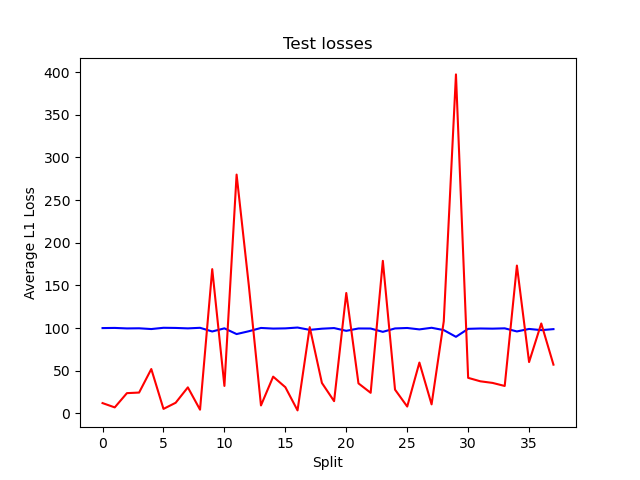

Text(0, 0.5, 'Average L1 Loss')

In [37]:
#do hold one out evaluation, train on all but 1 sample, test on the sample
from sklearn.model_selection import LeaveOneOut

train_losses = []
test_losses = []

#model = RNN(num_features, n_hidden, 1).float()

#for epoch in range(1, n_epochs + 1):
loo = LeaveOneOut()
train_losses=[]
test_losses=[]
for train_split, test_split in loo.split(X): #use the whole set
    model = LSTM(num_features, n_hidden, 1, num_news_features).float()
    #set the hold out example
    X_test = X[test_split,:]
    X_news_test = X_news[test_split,:]
    y_test = y[test_split]
    X_train = X[train_split,:]
    X_news_train = X_news[train_split,:]
    y_train = y[train_split]

    #do training
    l=0
    for i,x in enumerate(X_train):
        target = torch.tensor([y_train[i,0]])
        output, loss = train(x, target, X_news_train[i])
        l+=loss
    #train_loss+=l/len(X_train)
    train_losses.append(l/len(X_train))
    #do test
    output = test(X_test[0], X_news_test[0])
    loss = abs(y_test[0,0].item()-output.item())
    #test_loss+=loss
    test_losses.append(loss)
    
%matplotlib notebook
plt.plot(np.arange(0,len(X)-1), train_losses[0:-1], 'b')
plt.title("Average Training loss")
plt.xlabel("Split")
plt.ylabel("Average L1 Loss")

plt.plot(np.arange(0,len(X)-1), test_losses[0:-1], 'r')
plt.title("Test losses")
plt.xlabel("Split")
plt.ylabel("Average L1 Loss")

<IPython.core.display.Javascript object>


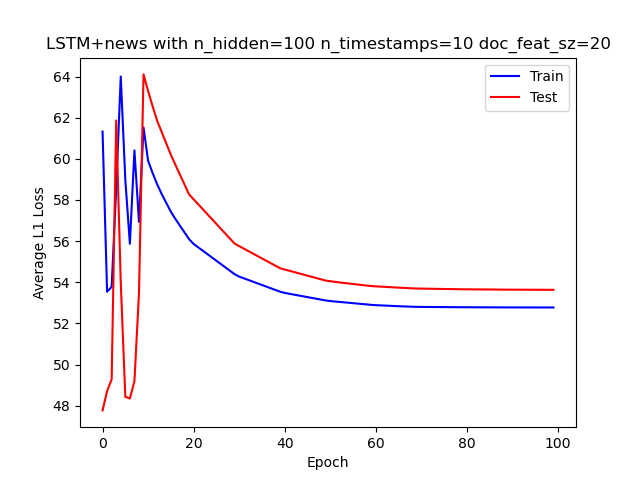

In [21]:
#run the training and testing procedures concurrently, showing progress of errors
#model = RNN(num_features, n_hidden, 1).float()

test_err_distribution = []
#repeat 10 times, average results
for z in range(10):
    train_inds = [random.randint(0, len(X)-1) for iter in range(math.floor((len(X)-1) * 0.8))]
    test_inds = np.setdiff1d(np.arange(0, len(X)-1), train_inds)

    X_train = torch.from_numpy(X.detach().numpy()[train_inds]).type(torch.DoubleTensor)
    X_news_train = torch.from_numpy(X_news.detach().numpy()[train_inds]).type(torch.DoubleTensor)
    y_train = torch.from_numpy(y.detach().numpy()[train_inds]).type(torch.DoubleTensor)
    X_test = torch.from_numpy(X.detach().numpy()[test_inds]).type(torch.DoubleTensor)
    X_news_test = torch.from_numpy(X_news.detach().numpy()[test_inds]).type(torch.DoubleTensor)
    y_test = torch.from_numpy(y.detach().numpy()[test_inds]).type(torch.DoubleTensor)   
    
    model = news_LSTM(num_features, n_hidden, 1, num_news_features).float()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    train_losses=[]
    test_losses = []
    for epoch in range(1, n_epochs + 1):
        #optimizer.zero_grad() # Clears existing gradients from previous epoch
        l=0
        for i,x in enumerate(X_train):
            target = torch.tensor([y_train[i,0]])
            output, loss = train(x, target,X_news_train[i])
            l+=loss
        train_losses.append(l/len(X_train))
        l=0
        for i,x in enumerate(X_test):
            target = torch.tensor([y_test[i,0]])
            output = test(x,X_news_test[i])
            loss = abs(target.item()-output.item())
            l+=loss
        test_losses.append(l/len(X_test))
        adjust_learning_rate(optimizer, epoch)
        
    test_err_distribution.append(test_losses[-1])
    if z==9:
        %matplotlib notebook
        plt.plot(np.arange(0,n_epochs), train_losses, 'b', label="Train")
        plt.plot(np.arange(0,n_epochs), test_losses, 'r', label="Test")
        plt.legend()
        plt.title("LSTM+news with n_hidden={} n_timestamps={} doc_feat_sz={}".format(n_hidden, seq_length, num_news_features))
        plt.xlabel("Epoch")
        plt.ylabel("Average L1 Loss")
        plt.savefig("newslstm_n{}_t{}_doc{}_loss.png".format(n_hidden,seq_length, num_news_features), bbox_inches='tight')

In [23]:
print(mean(test_err_distribution))
print(stdev(test_err_distribution))

48.87051752715017
10.467482114890794
